In [ ]:
import numpy as np
import pandas as pd
import time
from tensorflow import keras
from keras import layers
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
import gensim, re
import numpy as np
import pandas as pd
import pickle
from os import listdir
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import time
import sys
import os
import re
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer

from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Embedding


In [ ]:
with open("/Data/viettel_train_input.txt","r",encoding='UTF-8') as f:
  X_train=f.read().splitlines()
with open("/Data/viettel_train_label.txt","r",encoding='UTF-8') as f:
  y_train=f.read().splitlines()
with open("/Data/viettel_test_input.txt","r",encoding='UTF-8') as f:
  X_test=f.read().splitlines()
with open("/Data/viettel_test_label.txt","r",encoding='UTF-8') as f:
  y_test=f.read().splitlines()

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=44)


In [ ]:
X_train[0]

'hoạt_động có_thể hệ_thống thông_tin kinh_tế thương_mại điện_tử khoa động sinh_viên trường một_số hoạt_động có_thể tiêu_biểu trào dân_sinh_viên hay_là khóa học ngoại_khoa_ngoại khóa miễn_phí khoa phối_hợp doanh_nghiệp thương_mại điện_tử uy_tín tổ_chức khóa học phây facebook phét google ép hay_là kỹ_năng hàng a ma dôn truyền_thông mạng xã_hội hay_là photo sốp kỹ_năng thiết_thực có_thể giúp sinh_viên đáp_ứng lập_tức yêu_cầu doanh_nghiệp đi không_thể nhắc hoạt_động truyền_thống khoa hội hướng_nghiệp hoạt_động duy_trì mười khoa hệ_thống thông_tin kinh_tế thương_mại điện_tử hoạt_động vừa_rồi ngọc chia_sẻ hoạt_động liên_quan chuyên_ngành học ân_thắng có_thể chia_sẻ hoạt_động thể_hiện năng_động sinh_viên đại_học thương_mại hình_như chia_sẻ đấy hoạt_động liên_quan chuyên_ngành hoạt_động liên_quan năng_động sinh_viên hệ_thống thông_tin kinh_tế thương_mại điện_tử có_thể chương_trình tìm_kiếm tài_năng khoa ét có_thai li giải bóng_đá liên khoa tọa đàm hướng_nghiệp chuyên_ngành tham_gia diễn giả nổ

In [ ]:
class count_tf_idf:
  def __init__(self):
    self.cv=CountVectorizer(ngram_range=(1,1),
                   max_df=0.8,
                   max_features=None)
    self.tf_idf_transform=TfidfTransformer(smooth_idf=True,use_idf=True)
  def fit(self,docs):
    word_count_vector=self.cv.fit_transform(docs)
    self.tf_idf_transform.fit(word_count_vector)
  def transform(self,docs):
    count_vector=self.cv.transform(docs)
    return self.tf_idf_transform.transform(count_vector)
  def fit_transform(self,docs):
    word_count_vector=self.cv.fit_transform(docs)
    return self.tf_idf_transform.fit_transform(word_count_vector)

In [ ]:
tf_idf=count_tf_idf()
X_train_vectorized=tf_idf.fit_transform(X_train).toarray()

In [ ]:
labels=list(set(y_train))
label2id=dict([label,id] for id,label in enumerate(labels))
y_train_vectorized=[label2id[label] for label in y_train]
y_test_vectorized=[label2id[label] for label in y_test]

In [ ]:
y_train_vectorized=np.array(y_train_vectorized)
y_test_vectorized=np.array(y_test_vectorized)

In [ ]:
NUM_CLASSES=len(labels)
vocab_size=X_train_vectorized.shape[1]
model = keras.Sequential(
    [
        layers.Input(shape=(vocab_size)),
        layers.Dense(1024,activation='relu'),
        layers.Dropout(0.1),
        layers.Dense(512, activation="relu"),
        layers.Dense(256, activation="relu"),
        layers.Dense(NUM_CLASSES, activation="softmax"),
    ]
)
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
checkpoint_filepath="/tf-idf-weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint=ModelCheckpoint(checkpoint_filepath, 
                monitor = 'val_accuracy', 
                verbose = 1, 
                save_best_only = True, 
                mode = 'max')
callbacks_list = [checkpoint]
history=model.fit(X_train_vectorized,y_train_vectorized, epochs=10,batch_size=32,validation_split=0.1,verbose=1,callbacks = callbacks_list)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 1024)              22488064  
                                                                 
 dropout_3 (Dropout)         (None, 1024)              0         
                                                                 
 dense_13 (Dense)            (None, 512)               524800    
                                                                 
 dense_14 (Dense)            (None, 256)               131328    
                                                                 
 dense_15 (Dense)            (None, 22)                5654      
                                                                 
Total params: 23,149,846
Trainable params: 23,149,846
Non-trainable params: 0
_________________________________________________________________

Epoch 1: val_accuracy improved from -inf 

In [ ]:
model.load_weights("/tf-idf-weights-improvement-03-0.96.hdf5")
model.evaluate(X_train_vectorized)


181/181 [==============================] - 1s 2ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00


[0.0, 0.0]

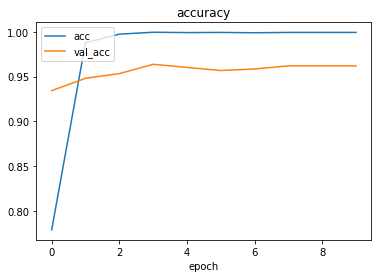

In [ ]:
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('accuracy')
plt.xlabel('epoch')
plt.legend(['acc', 'val_acc'], loc='upper left')
plt.show()

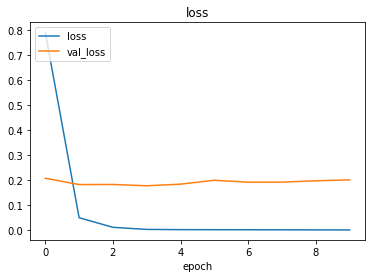

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper left')

In [ ]:
model.evaluate(X_test_vectorized, y_test_vectorized, batch_size=128)

12/12 [==============================] - 3s 208ms/step - loss: 0.1604 - accuracy: 0.9626


[0.16041243076324463, 0.9626038670539856]

In [ ]:
pred = model.predict(X_test_vectorized) 
pred = np.argmax(pred, axis = 1)
pred

array([15, 12, 15, ..., 17, 15,  4])

In [ ]:
from sklearn.metrics import plot_confusion_matrix
cnf_matrix = confusion_matrix(y_test_vectorized, pred)

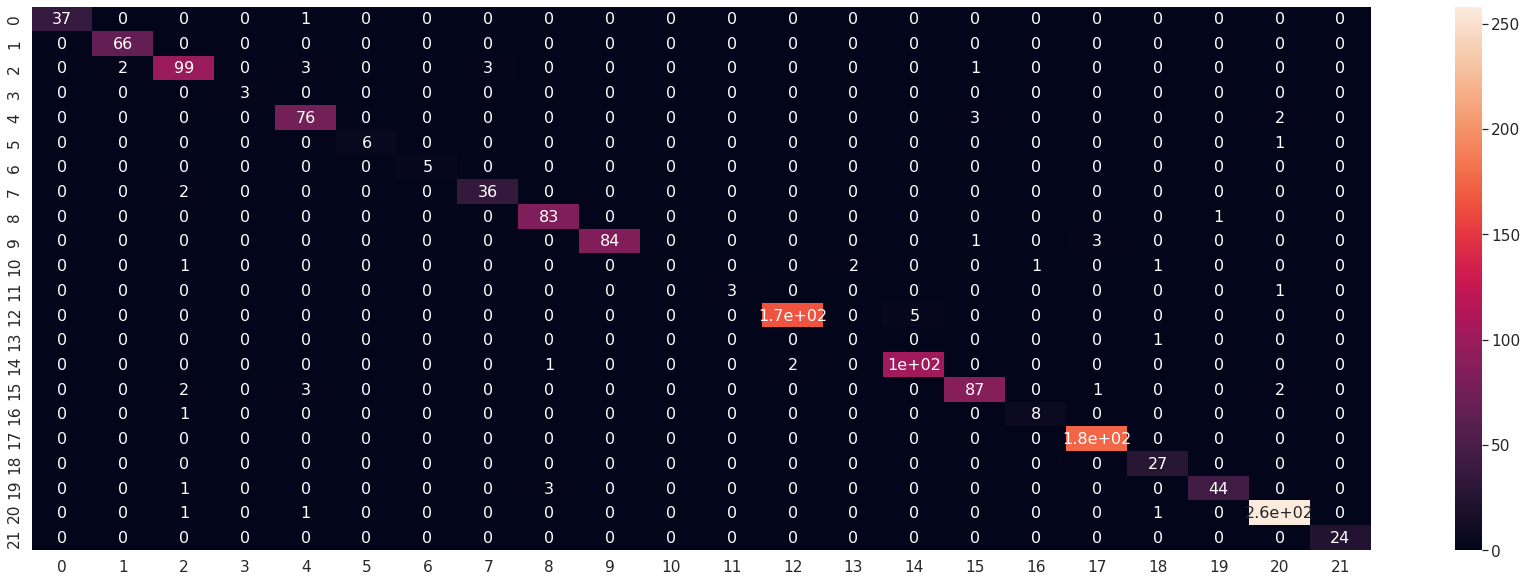

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
df_cm = pd.DataFrame(cnf_matrix)
plt.figure(figsize=(30,10))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size

plt.show()